<a href="https://colab.research.google.com/github/Ansalgadulu/Deep-Learning/blob/main/Porter_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

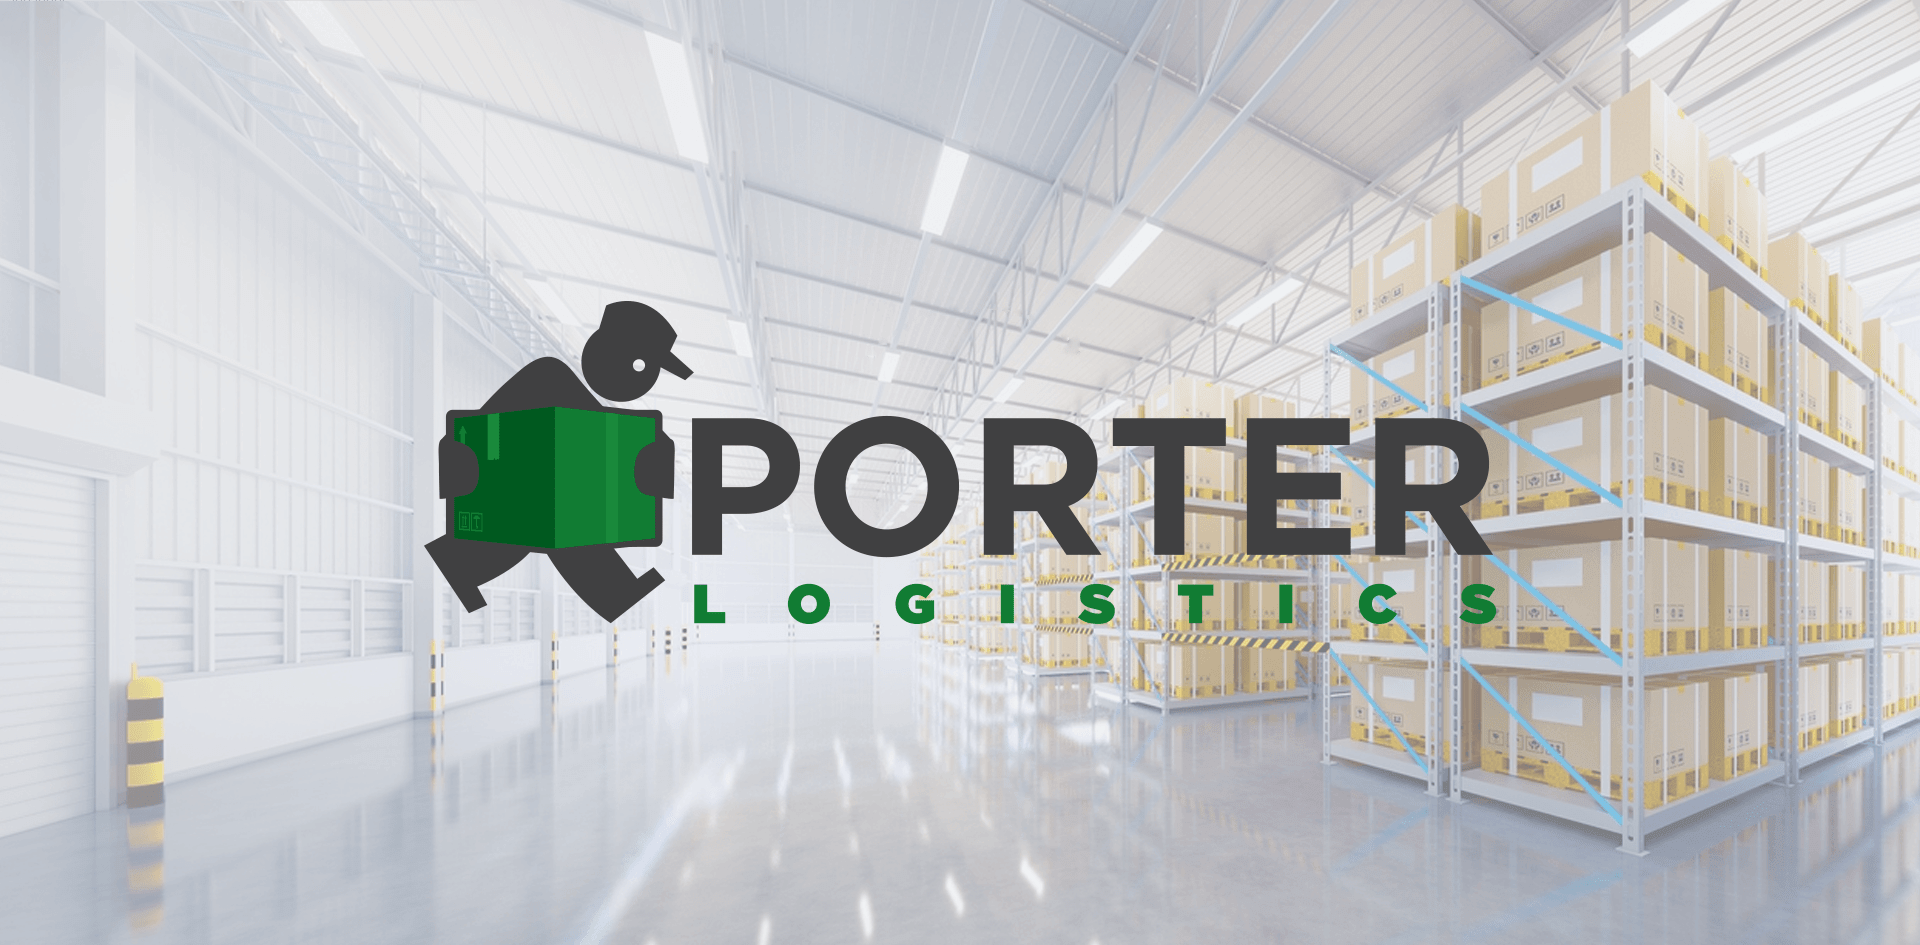

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib_inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score,mean_absolute_percentage_error
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.impute import KNNImputer
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


##Intro

In [ ]:
df=pd.read_csv('dataset.csv')
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  
0                    33.0                 14.0                      21.0  
1                     1.0                  2.0                       2.0  
2                     1.0                  0.0                       0.0  
3                     1.0                  1.0                       2.0  
4                     6.0                  6.0                       9.0

In [ ]:
df.shape# our data has 14 features and 197428 rows of data

(197428, 14)

Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below.

1. market_id : integer id for the market where the restaurant lies
2. created_at : the timestamp at which the order was placed
3. actual_delivery_time : the timestamp when the order was delivered
4. store_primary_category : category for the restaurant
5. order_protocol : integer code value for order protocol(how the order was 6.
6. placed ie: through porter, call to restaurant, pre booked, third part etc)
7. total_items subtotal : final price of the order
8. num_distinct_items : the number of distinct items in the order
9. min_item_price : price of the cheapest item in the order
10. max_item_price : price of the costliest item in order
11. total_onshift_partners : number of delivery partners on duty at the time 12.order was placed
12. total_busy_partners : number of delivery partners attending to other tasks
13. total_outstanding_orders : total number of orders to be fulfilled at the moment

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

##Missing value detection and treatment

In [ ]:
#lets check if any missing values in the above mentioned fields and other before doing the substraction
missing_percentages = df.isnull().mean() * 100

print(missing_percentages)


market_id                   0.499929
created_at                  0.000000
actual_delivery_time        0.003546
store_id                    0.000000
store_primary_category      2.411006
order_protocol              0.503981
total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.000000
max_item_price              0.000000
total_onshift_partners      8.236927
total_busy_partners         8.236927
total_outstanding_orders    8.236927
dtype: float64


In [ ]:
#lets drop the rows with missing values in columns where missing value percentage is less than 1
sub_set=missing_percentages.reset_index()[missing_percentages.reset_index()[0]<1.0]['index'].tolist()
print(sub_set)


['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price']


In [ ]:
df.dropna(subset=sub_set, inplace=True)#drop missing values in the columns created at and actual delivery time

In [ ]:
missing_percentages = df.isnull().mean() * 100

print(missing_percentages)

market_id                   0.000000
created_at                  0.000000
actual_delivery_time        0.000000
store_id                    0.000000
store_primary_category      2.044139
order_protocol              0.000000
total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.000000
max_item_price              0.000000
total_onshift_partners      8.242908
total_busy_partners         8.242908
total_outstanding_orders    8.242908
dtype: float64


In [ ]:
#lets check the columns one at a time starting from store_primary category
df['store_primary_category'].unique()
#as we can see in the below list there is nan in this list , lets replace the nan with others

array(['american', 'mexican', nan, 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'breakfast', 'mediterranean', 'japanese', 'greek',
       'catering', 'filipino', 'convenience-store', 'other', 'korean',
       'vegan', 'asian', 'barbecue', 'fast', 'dessert', 'smoothie',
       'seafood', 'vietnamese', 'cajun', 'steak', 'middle-eastern',
       'soup', 'vegetarian', 'persian', 'nepalese', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'burmese', 'british',
       'pasta', 'alcohol', 'dim-sum', 'peruvian', 'turkish', 'malaysian',
       'ethiopian', 'afghan', 'bubble-tea', 'german', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'gastropub',
       'pakistani', 'moroccan', 'spanish', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine',
       'kosher', 'irish', 'lebanese', 'belgian', 'indonesian',
       'alcohol-plus-food'], dtype=object)

In [ ]:
df['store_primary_category'].fillna('Others',inplace=True)
len(df[df['store_primary_category'].isna()])# we have filled the nan with missing for store category

0

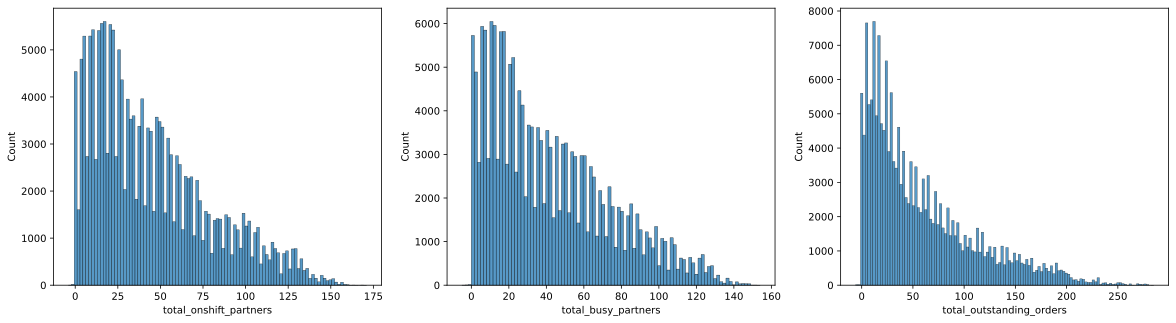

In [ ]:
# checking columns total_outstanding_orders,total_onshift_partners and total_busy_partners
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 5))
plt.subplot(131)
sns.histplot(df['total_onshift_partners'])
plt.subplot(132)
sns.histplot(df['total_busy_partners'])
plt.subplot(133)
sns.histplot(df['total_outstanding_orders'])
plt.show()

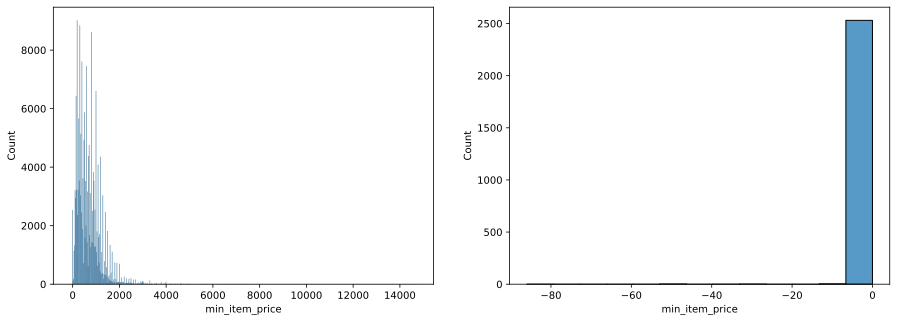

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
plt.subplot(121)
sns.histplot(df['min_item_price'])
plt.subplot(122)
sns.histplot(df['min_item_price'][df['min_item_price']<=0])
# we can see some of the minimum prices are less than zero , we are replacing those values with median as well
plt.show()

In [ ]:
#we will replace all the values less than 0 for columns total_outstanding_orders,total_onshift_partners and total_busy_partners with 0 and missing ones with median
# for i in ['total_outstanding_orders','total_onshift_partners','total_busy_partners','min_item_price']:
#   median_value = df[i].median()
#   df[i].fillna(median_value, inplace=True)
#   df[i] = df[i].where(df[i]>0, 0)

In [ ]:
missing_percentages = df.isnull().mean() * 100

print(missing_percentages)# no missing values

market_id                   0.000000
created_at                  0.000000
actual_delivery_time        0.000000
store_id                    0.000000
store_primary_category      0.000000
order_protocol              0.000000
total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.000000
max_item_price              0.000000
total_onshift_partners      8.242908
total_busy_partners         8.242908
total_outstanding_orders    8.242908
dtype: float64


In [ ]:
# we need to convert data type for columns created at and actual delivery time to date time format
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], format='%Y-%m-%d %H:%M:%S')



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195926 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 195926 non-null  float64       
 1   created_at                195926 non-null  datetime64[ns]
 2   actual_delivery_time      195926 non-null  datetime64[ns]
 3   store_id                  195926 non-null  object        
 4   store_primary_category    195926 non-null  object        
 5   order_protocol            195926 non-null  float64       
 6   total_items               195926 non-null  int64         
 7   subtotal                  195926 non-null  int64         
 8   num_distinct_items        195926 non-null  int64         
 9   min_item_price            195926 non-null  int64         
 10  max_item_price            195926 non-null  int64         
 11  total_onshift_partners    179776 non-null  float64       
 12  to

In [ ]:
df.describe()

market_id  order_protocol    total_items       subtotal  \
count  195926.000000   195926.000000  195926.000000  195926.000000   
mean        2.978574        2.882185       3.196630    2682.229158   
std         1.524856        1.503725       2.669461    1823.342124   
min         1.000000        1.000000       1.000000       0.000000   
25%         2.000000        1.000000       2.000000    1400.000000   
50%         3.000000        3.000000       3.000000    2200.000000   
75%         4.000000        4.000000       4.000000    3395.000000   
max         6.000000        7.000000     411.000000   27100.000000   

       num_distinct_items  min_item_price  max_item_price  \
count       195926.000000   195926.000000   195926.000000   
mean             2.670855      686.258649     1159.577938   
std              1.630765      522.217948      558.572523   
min              1.000000      -86.000000        0.000000   
25%              1.000000      299.000000      800.000000   
50%              2.000000      595.000000     1095.000000   
75%              3.000000      949.000000     1395.000000   
max             20.000000    14700.000000    14700.000000   

       total_onshift_partners  total_busy_partners  total_outstanding_orders  
count           179776.000000        179776.000000             179776.000000  
mean                44.801375            41.734892                 58.038287  
std                 34.523772            32.144906                 52.657970  
min                 -4.000000            -5.000000                 -6.000000  
25%                 17.000000            15.000000                 17.000000  
50%                 37.000000            34.000000                 41.000000  
75%                 65.000000            62.000000                 85.000000  
max                171.000000           154.000000                285.000000

In [ ]:
#adding target column
df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df.head(5)

market_id          created_at actual_delivery_time  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0 2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0 2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0 2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                 Others             1.0   
3  f0ade77b43923b38237db569b016ba25                 Others             1.0   
4  f0ade77b43923b38237db569b016ba25                 Others             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  \
0                    33.0                 14.0                      21.0   
1                     1.0                  2.0                       2.0   
2                     1.0                  0.0                       0.0   
3                     1.0                  1.0                       2.0   
4                     6.0                  6.0                       9.0   

   delivery_time  
0      62.983333  
1      67.066667  
2      29.683333  
3      51.250000  
4      39.833333

The target variable we can extract as delivery time , by substracing actual_delivery_time and the created_at

In [ ]:
df['delivery_time'].isna().sum()#no missing values in our target variable

0

##Feature Engineering

In [ ]:
#lets extract column order day and hour from created at and use them as columns
df['order_hour']=df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.day_name()

In [ ]:
df.head()

market_id          created_at actual_delivery_time  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0 2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0 2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0 2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                 Others             1.0   
3  f0ade77b43923b38237db569b016ba25                 Others             1.0   
4  f0ade77b43923b38237db569b016ba25                 Others             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  \
0                    33.0                 14.0                      21.0   
1                     1.0                  2.0                       2.0   
2                     1.0                  0.0                       0.0   
3                     1.0                  1.0                       2.0   
4                     6.0                  6.0                       9.0   

   delivery_time  order_hour order_day  
0      62.983333          22    Friday  
1      67.066667          21   Tuesday  
2      29.683333          20  Thursday  
3      51.250000          21   Tuesday  
4      39.833333           2    Sunday

##Vizulisation with Outlier detection and Treatment

In [ ]:
#lets list all the columns we have
df.columns.tolist()

['market_id',
 'created_at',
 'actual_delivery_time',
 'store_id',
 'store_primary_category',
 'order_protocol',
 'total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_partners',
 'total_busy_partners',
 'total_outstanding_orders',
 'delivery_time',
 'order_hour',
 'order_day']

In [ ]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
numerical_columns

['market_id',
 'order_protocol',
 'total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_partners',
 'total_busy_partners',
 'total_outstanding_orders',
 'delivery_time',
 'order_hour']

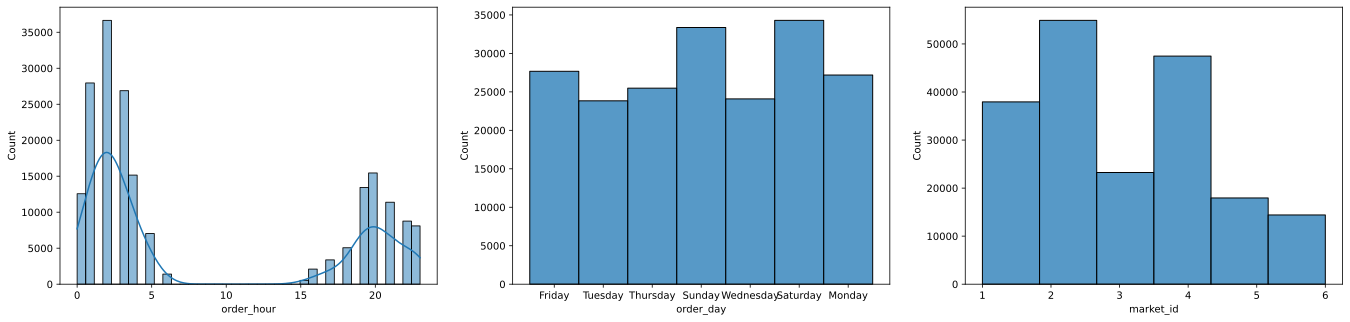

In [ ]:
#lets do a count plot for all the categorical columns
cat_cols=['order_hour','order_day','order_protocol','num_distinct_items','market_id','total_items']
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(23, 5))
plt.subplot(131)
sns.histplot(df['order_hour'],kde=True)
plt.subplot(132)
sns.histplot(df['order_day'])
plt.subplot(133)
sns.histplot(df['market_id'],bins=6)
plt.show()

Insights from above charts:
1.  Weekends have more orders
2.  the maximum numbers are placed around 2 am midnight and 8 pm in the evening and they almost follow normal distibutions with 2 means at 2 am and 8 pm
3.  market id 2, 4  and 1 have higher order volumes


<Axes: xlabel='order_protocol', ylabel='Count'>

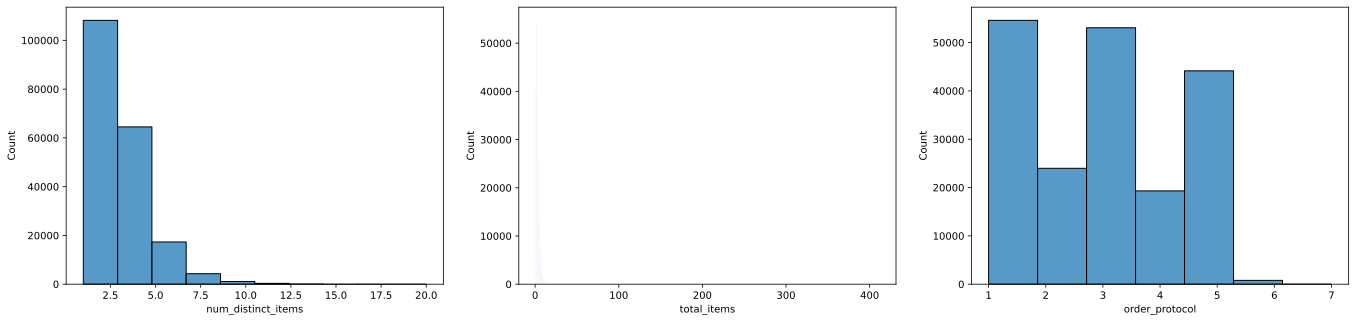

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(23, 5))
plt.subplot(131)
sns.histplot(df['num_distinct_items'],bins=10)
plt.subplot(132)
sns.histplot(df['total_items'])
plt.subplot(133)
sns.histplot(df['order_protocol'],bins=7)

total items seems to have data of a very wide range ,lets do a boxplot to check

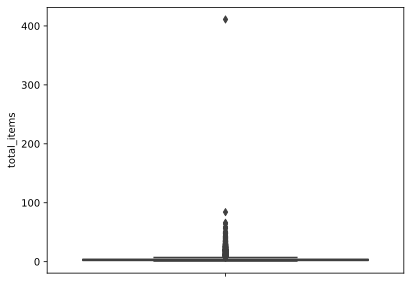

In [ ]:
sns.boxplot(y=df['total_items'])
plt.show()

In [ ]:
# Let's correct the outliers in total items and no. of distinct items using IQR method
def iqr(column_name):
      q1 = df[column_name].quantile(0.10)
      q3 = df[column_name].quantile(0.90)
      iqr = q3 - q1
      lower_threshold = q1 - 1.5 * iqr
      upper_threshold = q3 + 1.5 * iqr

      # Winsorize the outliers
      df[column_name] = np.where(df[column_name] < lower_threshold, lower_threshold, df[column_name])
      df[column_name] = np.where(df[column_name] > upper_threshold, upper_threshold, df[column_name])

<Axes: xlabel='order_protocol', ylabel='Count'>

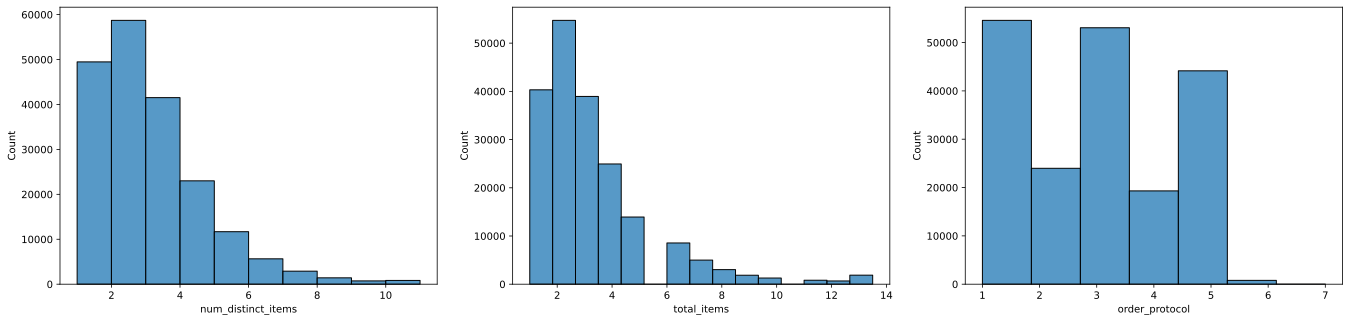

In [ ]:
for i in ['num_distinct_items','total_items']:
  iqr(i)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(23, 5))
plt.subplot(131)
sns.histplot(df['num_distinct_items'],bins=10)
plt.subplot(132)
sns.histplot(df['total_items'],bins=15)
plt.subplot(133)
sns.histplot(df['order_protocol'],bins=7)

insights:
1.  the num of items orderd and total items ordered at a time is right skewed meaning most orders have count which are in the lower range
2.  order_protocol 1,3 and 5 are most used

In [ ]:
cols_to_scale=['subtotal',
 'min_item_price',
 'max_item_price',
 'total_onshift_partners',
 'total_busy_partners',
 'total_outstanding_orders']
for i in cols_to_scale:
  iqr(i)

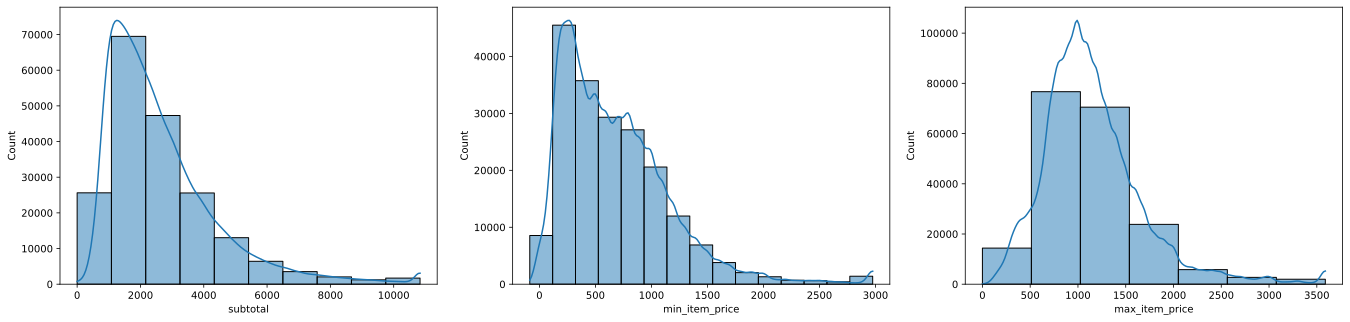

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(23, 5))
plt.subplot(131)
sns.histplot(df['subtotal'],bins=10,kde=True)
plt.subplot(132)
sns.histplot(df['min_item_price'],bins=15,kde=True)
plt.subplot(133)
sns.histplot(df['max_item_price'],bins=7,kde=True)
plt.show()

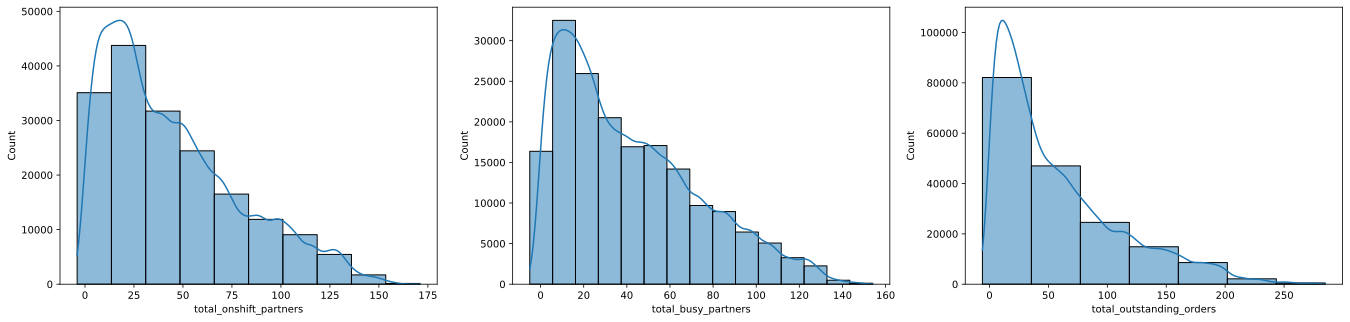

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(23, 5))
plt.subplot(131)
sns.histplot(df['total_onshift_partners'],bins=10,kde=True)
plt.subplot(132)
sns.histplot(df['total_busy_partners'],bins=15,kde=True)
plt.subplot(133)
sns.histplot(df['total_outstanding_orders'],bins=7,kde=True)
plt.show()

Insights:
1.  the distribution of features min_price,max_price,sub total,total onshift parterns are right skewed distributions

Bivariate Analysis

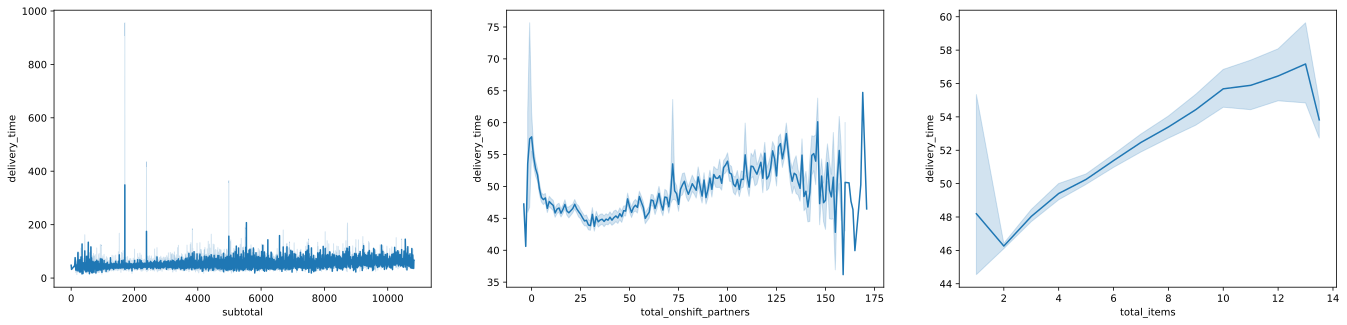

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(23, 5))
plt.subplot(131)
sns.lineplot(y=df['delivery_time'],x=df['subtotal'])
plt.subplot(132)
sns.lineplot(y=df['delivery_time'],x=df['total_onshift_partners'])
plt.subplot(133)
sns.lineplot(y=df['delivery_time'],x=df['total_items'])
plt.show()

Insights:
1.  no specific relationship between delivery time and sub total and total onshift partners,although the time is peaking when the partners are below 25
2. delivery time increases as the total number of items ordered increases


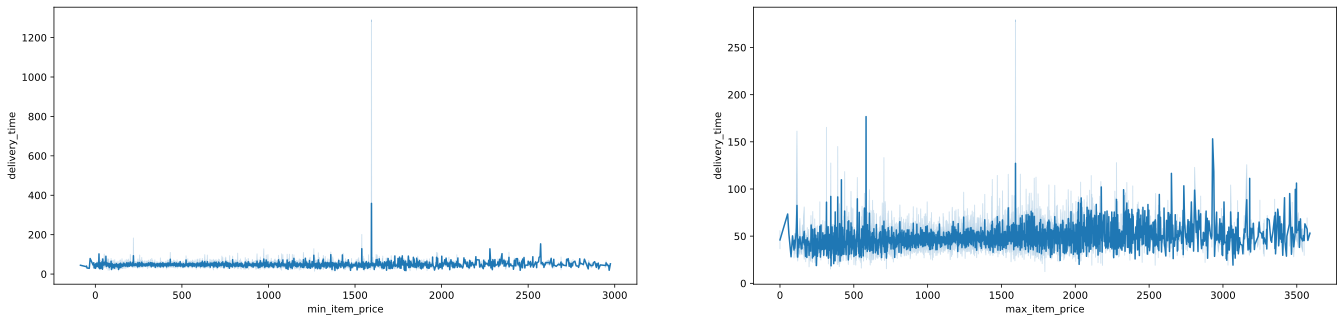

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(23, 5))
plt.subplot(121)
sns.lineplot(y=df['delivery_time'],x=df['min_item_price'])
plt.subplot(122)
sns.lineplot(y=df['delivery_time'],x=df['max_item_price'])

plt.show()

In [ ]:
df.head()

market_id          created_at actual_delivery_time  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0 2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0 2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0 2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                 Others             1.0   
3  f0ade77b43923b38237db569b016ba25                 Others             1.0   
4  f0ade77b43923b38237db569b016ba25                 Others             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0          4.0    3441.0                 4.0           557.0          1239.0   
1          1.0    1900.0                 1.0          1400.0          1400.0   
2          1.0    1900.0                 1.0          1900.0          1900.0   
3          6.0    6900.0                 5.0           600.0          1800.0   
4          3.0    3900.0                 3.0          1100.0          1600.0   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  \
0                    33.0                 14.0                      21.0   
1                     1.0                  2.0                       2.0   
2                     1.0                  0.0                       0.0   
3                     1.0                  1.0                       2.0   
4                     6.0                  6.0                       9.0   

   delivery_time  order_hour order_day  
0      62.983333          22    Friday  
1      67.066667          21   Tuesday  
2      29.683333          20  Thursday  
3      51.250000          21   Tuesday  
4      39.833333           2    Sunday

<ipython-input-166-2bff32da518f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='pearson'), square=True,annot=True, cmap="Blues")


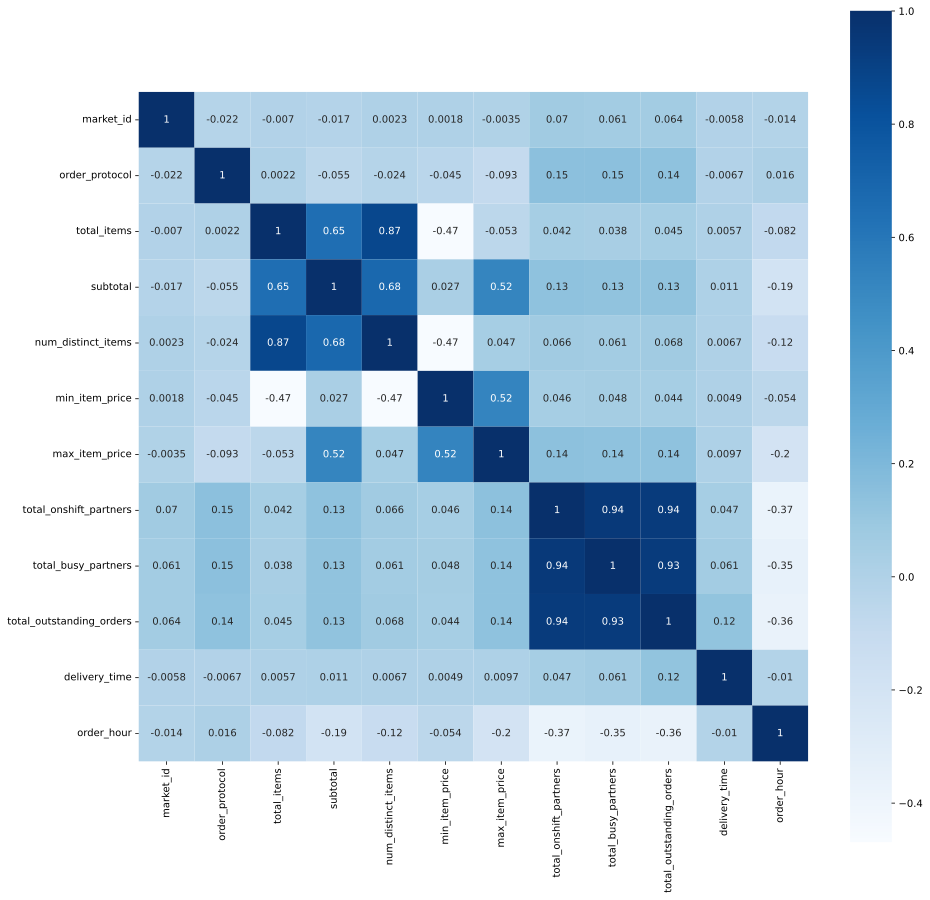

In [ ]:
#Heat map comparing all fields
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(method='pearson'), square=True,annot=True, cmap="Blues")
plt.show()

In [ ]:
# we can see some features which are highly correlated (>0.9) we should drop features like total outstanding orders and total busy partners
df.drop(['total_outstanding_orders','total_busy_partners','num_distinct_items'],axis=1,inplace=True)

##Base line Model(random forest)

In [ ]:

# Splitting the data into features (X) and target variable (y)
X = df.drop(['delivery_time','created_at','actual_delivery_time'], axis=1)
y = df['delivery_time']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#encoding
target_encoder = ce.TargetEncoder(cols=['market_id','store_id','store_primary_category','order_protocol','order_day','order_hour'])

# Fit the TargetEncoder on the training set
target_encoder.fit(X_train, y_train)

# Transform the categorical column in both the training and test sets
X_train_encoded = target_encoder.transform(X_train)
X_test_encoded = target_encoder.transform(X_test)
fin_cols=X_train_encoded.columns.tolist()
#imputing missing values using KNN imputer
imputer = KNNImputer(n_neighbors=3)
imputer.fit(X_train_encoded)
X_train_encoded=imputer.transform(X_train_encoded)
X_test_encoded=imputer.transform(X_test_encoded)
#scaling
scaler=StandardScaler()
scaler.fit(X_train_encoded)
X_train_encoded_scaled=scaler.transform(X_train_encoded)
X_test_encoded_scaled=scaler.transform(X_test_encoded)

In [ ]:
# Create the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_encoded_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_encoded_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 290.0698697918289


In [ ]:
r2_rf=r2_score(y_test, y_pred)
mape_rf=mean_absolute_percentage_error(y_test, y_pred)
r2_rf,mape_rf

(0.17119503879528053, 0.27662184431431586)

##Neural Network

In [ ]:
X_train_encoded_scaled.shape

(156740, 11)


*   We tried relu activation which was not giving good MSE , after changing it to tanh the model MSE improved by 10 units , adding 4 dense layers gave us best val score of 278 MSE
*   introducing drop out and batch normalisation improved the loss minimisation over each epoch
*   We used call backs modelcheckpoint to capture best model and early stopping to improve train timing



In [ ]:
model = keras.Sequential()

# Add layers to the model
model.add(keras.layers.Dense(units=128, activation='tanh', input_shape=(11,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(keras.layers.Dense(units=64, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(keras.layers.Dense(units=32, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=16, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())

model.add(keras.layers.Dense(units=8, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.1)))

model.add(keras.layers.Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train_encoded_scaled, y_train, epochs=100, batch_size=128,  validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Load the best model
best_model = keras.models.load_model('best_model.h5')

# Evaluate the best model
loss = best_model.evaluate(X_test_encoded_scaled, y_test)
print("Mean Squared Error:", loss)

Epoch 1/100
980/980 [==============================] - 6s 4ms/step - loss: 163249.9531 - val_loss: 1602.2010
Epoch 2/100
980/980 [==============================] - 3s 4ms/step - loss: 162664.0469 - val_loss: 1246.4067
Epoch 3/100
980/980 [==============================] - 3s 3ms/step - loss: 162318.0469 - val_loss: 954.3033
Epoch 4/100
980/980 [==============================] - 3s 3ms/step - loss: 162057.7656 - val_loss: 745.0251
Epoch 5/100
980/980 [==============================] - 4s 4ms/step - loss: 161870.2500 - val_loss: 593.2932
Epoch 6/100
980/980 [==============================] - 3s 3ms/step - loss: 161745.0000 - val_loss: 510.5179
Epoch 7/100
980/980 [==============================] - 3s 3ms/step - loss: 161662.2031 - val_loss: 443.3333
Epoch 8/100
980/980 [==============================] - 4s 4ms/step - loss: 161605.2344 - val_loss: 406.8524
Epoch 9/100
980/980 [==============================] - 3s 3ms/step - loss: 161569.5312 - val_loss: 380.9659
Epoch 10/100
980/980 [====

In [ ]:
Y_pred_NN=best_model.predict(X_test_encoded_scaled)

1225/1225 [==============================] - 2s 1ms/step


In [ ]:
r2_nn=r2_score(y_test, Y_pred_NN)# we got a r2 score of 0.21,
r2_nn


0.20702732997030548

In [ ]:
mape_nn=mean_absolute_percentage_error(y_test, Y_pred_NN)# the mean error is around 26 %
mape_nn

0.2701114561151918

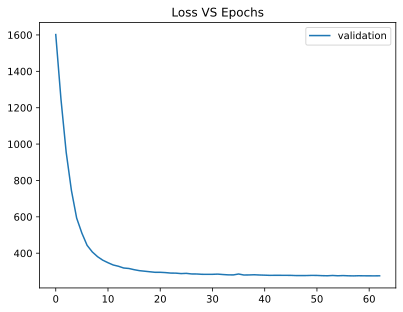

In [ ]:
epochs = history.epoch

val_loss = history.history["val_loss"]
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()# we have acheieved loss better than our base model


In [ ]:
model = keras.Sequential()

# Add layers to the model
model.add(keras.layers.Dense(units=256, activation='tanh', input_shape=(11,)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(keras.layers.Dense(units=128, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.5)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(keras.layers.Dense(units=64, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=32, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(BatchNormalization())

model.add(keras.layers.Dense(units=16, activation='tanh',  kernel_regularizer=keras.regularizers.l2(0.05)))

model.add(keras.layers.Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train_encoded_scaled, y_train, epochs=100, batch_size=128,  validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Load the best model
best_model = keras.models.load_model('best_model.h5')

# Evaluate the best model
loss = best_model.evaluate(X_test_encoded_scaled, y_test)
print("Mean Squared Error:", loss)

Epoch 1/100
980/980 [==============================] - 7s 6ms/step - loss: 162850.8125 - val_loss: 1042.3816
Epoch 2/100
980/980 [==============================] - 5s 5ms/step - loss: 162083.1875 - val_loss: 698.6696
Epoch 3/100
980/980 [==============================] - 5s 5ms/step - loss: 161777.0469 - val_loss: 493.9737
Epoch 4/100
980/980 [==============================] - 5s 5ms/step - loss: 161635.5781 - val_loss: 412.7798
Epoch 5/100
980/980 [==============================] - 5s 5ms/step - loss: 161556.1719 - val_loss: 359.6242
Epoch 6/100
980/980 [==============================] - 6s 6ms/step - loss: 161514.0312 - val_loss: 340.2848
Epoch 7/100
980/980 [==============================] - 5s 5ms/step - loss: 161490.7812 - val_loss: 325.7795
Epoch 8/100
980/980 [==============================] - 6s 6ms/step - loss: 161475.6719 - val_loss: 316.8825
Epoch 9/100
980/980 [==============================] - 5s 5ms/step - loss: 161465.8125 - val_loss: 319.0901
Epoch 10/100
980/980 [=====

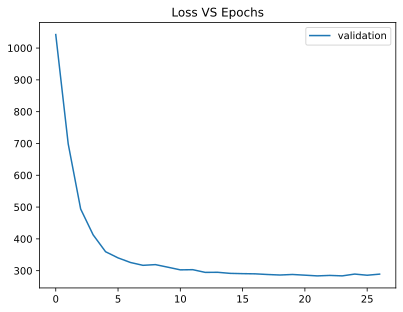

In [ ]:
epochs = history.epoch

val_loss = history.history["val_loss"]
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()# we have acheieved loss better than our base model


We tried a model with more connections still the performance didnt improve much

The MAPE for both the random forest and the NN is around 26 -28 %

## Comparison between metrics for NN and Random Forest


In [ ]:
# lets make a table comparing various metrics from the NN and the baseline random forest
pd.DataFrame({"MODEL": ["Neural_Network","Random Forest"], "MAPE":[mape_nn,mape_rf],"R2_Score":[r2_nn,r2_rf]})

MODEL      MAPE  R2_Score
0  Neural_Network  0.270111  0.207027
1   Random Forest  0.276622  0.171195

Our neural network has both better MAPE and significantly better r2 score as compared to random forest

The above models have performance not par to be used in production models the ways we can imporove this are by getting better quality data and trying out more combinations of hyper parameters for the neural networks